# Assignment 7

This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (Links to an external site.). .  (Links to an external site.)Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 


# Management Problem
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?



# Discussion
I have logged over 45 hours on this assignement and I am going to have to move on with really poor kaggle scores. I believe the issue with extremely poor kaggle scores is a result of the processing of the test images. On that specific task I have spent 15 unsuccessful hours. If I have time in week 10 I might come back and work on this.

In general it seems from the test data (which was split from the original training sets) that the grayscale images classify better than RGB images. Additionally, eliminating these extra channels decreases the quantity of data that needs to be stored and run through our model also decreasing the amount of time needed to train the model. Unfortunately I didn't get to a point where I could build much improvement into the model. If I were to improve this model I would add additional dense layers with dropout. Also potentially a third convolutional and pooling layer which uses more filters, likely with dropout as well. Dropout serves to decrease chances of overfitting the training data through regularization. It is also my belief that having the ability to increase the resolution on the original images should improve the accuracy of the model, however this will only incrase the quantity of time needed to train our model and we should weigh the consequences accordingly. Also, through this experiment including more images in the training set improved correct predicitons of the test observations (which were split from the oringinal training dataset). However, this will also come at the cost of extending the required training duration.



In [82]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
from PIL import Image
#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.image import imread
import matplotlib.image as mpimg
import scikitplot as skplt

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array

import pydot
import graphviz
import getpass
import smtplib

from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

RANDOM_SEED = 2


# 1) Data Preparation and EDA

In [83]:
Dogphotos = np.load('dogs_1000_64_64_3.npy')
scaled_DP = Dogphotos/255.
grayscaleDogs = np.load('dogs_1000_64_64_1.npy')
Catphotos = np.load('cats_1000_64_64_3.npy')
grayscaleCats = np.load('cats_1000_64_64_1.npy')
scaled_grayCats = grayscaleCats/255.
scaled_grayDogs =  grayscaleDogs/255.
scaled_CP = Catphotos/255.

catlabels= np.repeat(0,1000)
doglabels = np.repeat(1,1000)


## Example images of a dog and cat

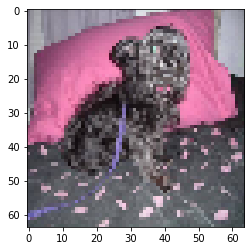

In [3]:
plt.imshow(scaled_DP[0, :, :, :])


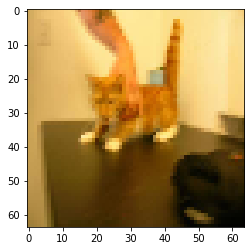

In [4]:
plt.imshow(scaled_CP[0, :, :, :])

## Combine the dogs and cats for grayscale and normal images (labels and images)  
    verify combination retrieves same photos by index

In [84]:
photos = np.append(scaled_CP, scaled_DP, axis=0)
#np.save('AssignmentTrainFeatures.npy', photos)
labels = np.append(catlabels, doglabels, axis=0)
#np.save('AssignmentTrainLables.npy',labels)
grayphotos= np.append(scaled_grayCats, scaled_grayDogs, axis =0)
#np.save('AssignmentGrayTrainFeatures.npy',grayphotos)

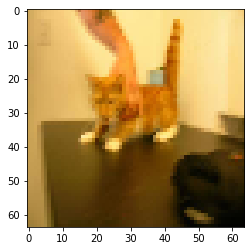

In [6]:
plt.imshow(photos[0, :, :, :])


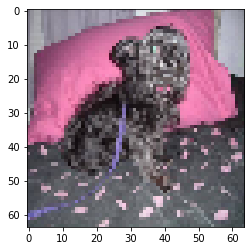

In [7]:
plt.imshow(photos[1000, :, :, :])


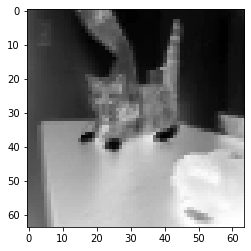

In [8]:
plt.imshow(grayphotos[0], cmap='gist_yarg')

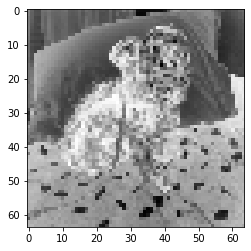

In [9]:
plt.imshow(grayphotos[1000], cmap='gist_yarg')

In [86]:
photos = np.load('AssignmentTrainFeatures.npy')
labels = np.load('AssignmentTrainLables.npy')
grayphotos= np.load('AssignmentGrayTrainFeatures.npy')
#labels = abs(labels - 1)

In [87]:
#shuffle the datasets so that we don't end up with vastly different proportions of cats/ dogs in validation and training sets.
X,  y = photos, labels

grayX, y = grayphotos, labels

## Train validation split

In [88]:
#split the datasets into train and validation for grayscale and normal images.
trainX, testX, trainy, testy = train_test_split( X, y, test_size=0.50, random_state=RANDOM_SEED)
valX, testX, valy, testy = train_test_split( testX, testy, test_size=0.20, random_state=RANDOM_SEED)


gray_trainX, gray_testX, gray_trainy, gray_testy  = train_test_split( grayX, y, test_size=0.50, random_state=RANDOM_SEED)
gray_valX, gray_testX, gray_valy, gray_testy  = train_test_split( gray_testX, gray_testy, test_size=0.20, random_state=RANDOM_SEED)





meanX = trainX.mean(axis=0, keepdims=True)
stdX = trainX.std(axis=0, keepdims=True) + 1e-7


meangX = gray_trainX.mean(axis=0, keepdims=True)
stdgX = gray_trainX.std(axis=0, keepdims=True)+ 1e-7


trainX = (trainX-meanX) / stdX
valX= (valX-meanX) / stdX
testX = (testX-meanX) / stdX

gray_trainX = (gray_trainX-meangX) / stdgX
gray_valX= (gray_valX-meangX) / stdgX
gray_testX = (gray_testX-meangX) / stdgX

In [13]:
grayX.shape

(2000, 64, 64, 1)

In [89]:
# checks proportions of 
print(np.mean(trainy))
print(np.mean(valy))

0.506
0.48375


In [90]:
trainX.shape

(1000, 64, 64, 3)

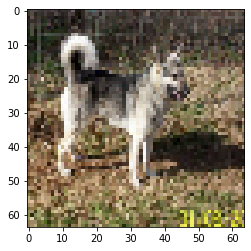

In [91]:
plt.imshow(trainX[900])

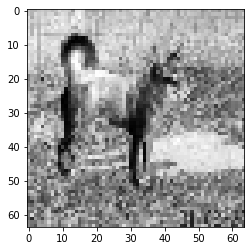

In [17]:
plt.imshow(gray_trainX[900], cmap='gist_yarg')

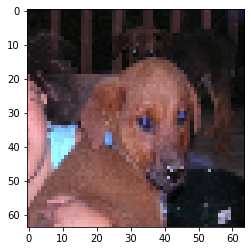

In [18]:
plt.imshow(valX[208])

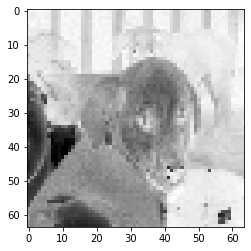

In [19]:
plt.imshow(gray_valX[208], cmap='gist_yarg')

## Prepare the test data for evaluation in 3 vs 1 channel (RGB vs grayscale)
    This is intentionally commented out to prevent disk writing and memory usage

In [20]:
#folder = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/test/'
#photos, names = list(), list()
        
#for file in os.listdir(folder):
	# load image and scale
#	photo = tf.keras.preprocessing.image.load_img(folder + file, target_size=(64, 64))
#	file = int(file.split(".", 1)[0])

	# convert to numpy array
#	photo = tf.keras.preprocessing.image.img_to_array(photo)

	# append each scaled photo to photo list
#	photos.append(photo)
#	names.append(file)

# convert list of arrays to array of arrays.
#photos = np.asarray(photos)
#names = np.asarray(names)
#print(photos.shape)

#save the reshaped photo array
#np.save('dogsNcatsTestFeatures.npy', photos)
#np.save('test_names.npy', names)

In [21]:
#grayphotos = list()
#for file in os.listdir(folder):
	# load image and scale    
#    grayphoto = tf.keras.preprocessing.image.load_img(folder + file, color_mode='grayscale', target_size=(64, 64))
	# convert to numpy array

#    grayphoto = tf.keras.preprocessing.image.img_to_array(grayphoto)
    # append each scaled photo to photo list
#    grayphotos.append(grayphoto)
    
#convert list of arrays to array of arrays.
#grayphotos = np.asarray(grayphotos)

#print(grayphotos.shape)
#save the reshaped photo array
#np.save('dogsNcatsTestGrayFeatures.npy', grayphotos)

## Prepare the kaggle training set in RGB and Grayscale
    This is intentionally commented out to prevent disk writing and memory usage

In [22]:
#Generates loops over ana classifies images (1=dog, 0=cat), resizes to 100x100 pixels and stores labels and features as independant arrays
#folder = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/train/'
#Kgrayphotos = list()
        
#for file in os.listdir(folder):
	
#    grayphoto = tf.keras.preprocessing.image.load_img(folder + file, color_mode='grayscale', target_size=(64, 64))
	# convert to numpy array

#    grayphoto = tf.keras.preprocessing.image.img_to_array(grayphoto)
    # append each scaled photo to photo list
#    grayphotos.append(grayphoto)
	# store
#    Kgrayphotos.append(grayphoto)

                # convert to a numpy arrays
#Kgrayphotos = np.asarray(Kgrayphotos)

#print(Kgrayphotos.shape)
# save the reshaped photos
#np.save('KagglegrayTrainFeatures.npy', Kgrayphotos)


In [23]:
#photos, labels = list(), list()
        
#for file in os.listdir(folder):
	        # determine class
#	output = 0.0
#	if file.startswith('dog'):
#		output = 1.0
	        # load image
#	photo = tf.keras.preprocessing.image.load_img(folder + file, target_size=(64, 64))
	# convert to numpy array
#	photo = tf.keras.preprocessing.image.img_to_array(photo)
	# store
#	photos.append(photo)
#	labels.append(output)
                # convert to a numpy arrays
#photos = np.asarray(photos)
#labels = np.asarray(labels)
#print(photos.shape, labels.shape)
# save the reshaped photos
#np.save('KaggleTrainFeatures.npy', photos)
#np.save('KaggleTainLabels.npy', labels)

## create logfile trigger

In [93]:
logdir = 'C:/Users/bblank/Documents/keras_logfiles'
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join('C:/Users/bblank/Documents/keras_logfiles', run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Prepared Dataset Summary


In [94]:
dataSummary = {
    'ImageSource': ['Assignment Prompt', 'Assignment Prompt', 'Kaggle', 'Kaggle', 'Kaggle', 'Kaggle'], 
    'Train/Test':  ['Train', 'Train', 'Train','Train','Test','Test'],
    'ColorChannels': [3,1,3,1,3,1],
    'Totalbservations': [2000,2000,25000,25000,12500 ,12500 ],    
        }

dataSummary_df = pd.DataFrame.from_dict(dataSummary)
display(dataSummary_df)

,ImageSource,Train/Test,ColorChannels,Totalbservations
0,Assignment Prompt,Train,3,2000
1,Assignment Prompt,Train,1,2000
2,Kaggle,Train,3,25000
3,Kaggle,Train,1,25000
4,Kaggle,Test,3,12500
5,Kaggle,Test,1,12500


# 2) Model Construction and diagrams

## RGB Model

In [95]:
#S10 Compile Model
model = keras.models.Sequential()
#input convolutional layer
model.add(keras.layers.Conv2D(32, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
model.add(keras.layers.Conv2D(256, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#flatten and fully connected layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dropout(0.6))

#output layer, binary response
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        6176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0

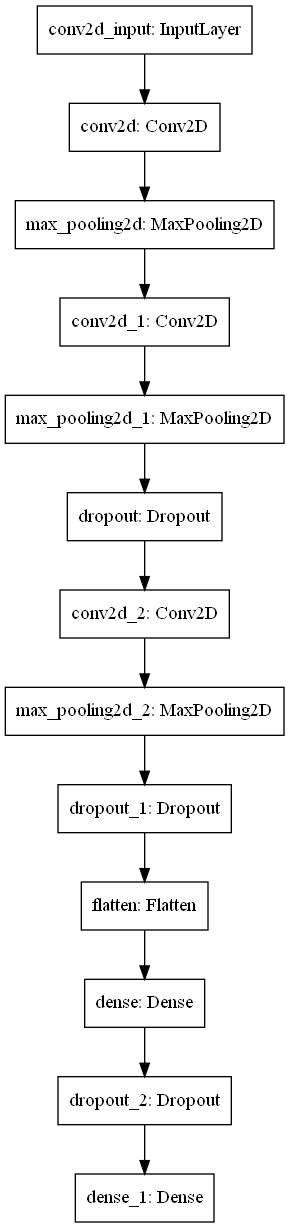

In [28]:
keras.utils.plot_model(model)

## Grayscale model

In [96]:
gray_model = keras.models.Sequential()
#input convolutional layer
gray_model.add(keras.layers.Conv2D(32, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 1)))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
gray_model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
gray_model.add(keras.layers.Conv2D(256, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#flatten and fully connected layer
gray_model.add(keras.layers.Flatten())
gray_model.add(keras.layers.Dense(500, activation='relu'))
gray_model.add(keras.layers.Dropout(0.6))

#output layer, binary response
gray_model.add(keras.layers.Dense(1, activation='sigmoid'))




In [30]:
gray_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         147712    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)        

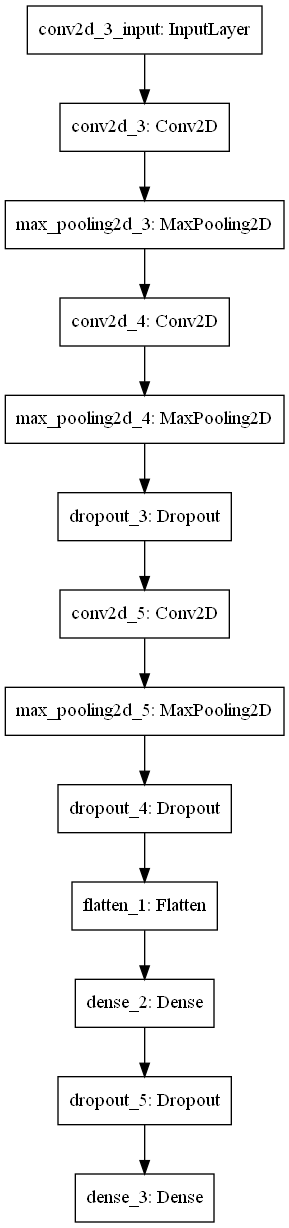

In [31]:
keras.utils.plot_model(gray_model)

# 3) Assignment Prompt RGB images (Train and Predictions)

In [97]:
before_fit = datetime.now()


early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=3, patience=18)

optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.1)

model.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
RGB_history = model.fit(trainX, trainy, epochs=100,
                    validation_data=(valX, valy),
                    callbacks=[tensorboard_cb, early_stopping_cb])

after_fit = datetime.now()


Epoch 1/100
32/32 [==============================] - 2s 54ms/step - loss: 0.6946 - accuracy: 0.5213 - val_loss: 0.6926 - val_accuracy: 0.5163
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6928 - accuracy: 0.5192 - val_loss: 0.6907 - val_accuracy: 0.5163
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6970 - accuracy: 0.4904 - val_loss: 0.6900 - val_accuracy: 0.5150
Epoch 4/100
32/32 [==============================] - 1s 27ms/step - loss: 0.6933 - accuracy: 0.5291 - val_loss: 0.6909 - val_accuracy: 0.5113
Epoch 5/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6901 - accuracy: 0.5274 - val_loss: 0.6872 - val_accuracy: 0.5688
Epoch 6/100
32/32 [==============================] - 1s 27ms/step - loss: 0.6909 - accuracy: 0.5227 - val_loss: 0.6868 - val_accuracy: 0.5863
Epoch 7/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6845 - accuracy: 0.5469 - val_loss: 0.6885 - val_accuracy: 0.5200
Epoch 

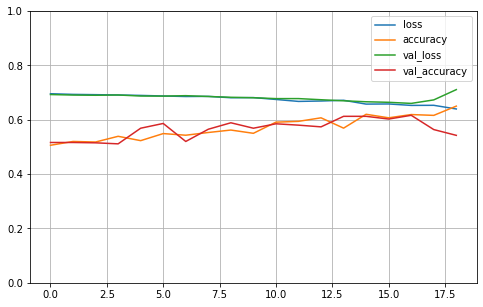

In [98]:
pd.DataFrame(RGB_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [100]:
elapsed =after_fit - before_fit
RGB_As_duration = elapsed.total_seconds()
print(RGB_As_duration)

18.629481


In [108]:
y_preds =(model.predict(testX) >0.62).astype("int32")

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

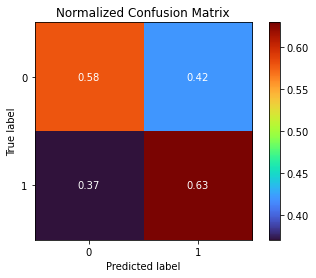

In [109]:
skplt.metrics.plot_confusion_matrix(testy, y_preds, normalize=True, cmap='turbo')

In [110]:
TestFeatures = np.load("C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/KaggleTestImages.npy")
TestFeatures = TestFeatures/255.



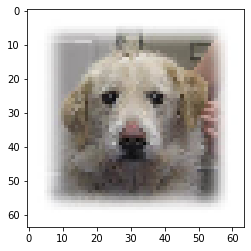

In [38]:
plt.imshow(TestFeatures[2])

In [111]:
As_RGB_TestPreds = (model.predict(TestFeatures) >0.39).astype("int32")
As_RGB_TestLabels = As_RGB_TestPreds.tolist()
As_RGB_TestLabels = [item for sublist in As_RGB_TestLabels for item in sublist]
names = np.linspace(1, len(TestFeatures), len(TestFeatures))
labels = pd.DataFrame({"id": names, "label": As_RGB_TestLabels})
labels.sort_values(by= 'id', inplace = True)
labels.to_csv('As_RGB_TestPreds.csv', index=False)

In [40]:
As_RGB_KaggleScore = 12.16339

# 4) Assignment Prompt grayscale images (Train and Predictions)

In [41]:

before_fit = datetime.now()


early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=3, patience=18)

optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.1)

gray_model.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
gray_history = gray_model.fit(gray_trainX, gray_trainy, epochs=100,
                    validation_data=(gray_valX, gray_valy),
                    callbacks=[tensorboard_cb, early_stopping_cb])

after_fit = datetime.now()


Epoch 1/100
32/32 [==============================] - 3s 67ms/step - loss: 0.6948 - accuracy: 0.4692 - val_loss: 0.6934 - val_accuracy: 0.4837
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6941 - accuracy: 0.5108 - val_loss: 0.6912 - val_accuracy: 0.5188
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6934 - accuracy: 0.5117 - val_loss: 0.6923 - val_accuracy: 0.4988
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.6916 - accuracy: 0.5359 - val_loss: 0.6902 - val_accuracy: 0.5213
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6905 - accuracy: 0.5237 - val_loss: 0.6903 - val_accuracy: 0.6100
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.6916 - accuracy: 0.5187 - val_loss: 0.6903 - val_accuracy: 0.5512
Epoch 7/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6877 - accuracy: 0.5701 - val_loss: 0.6896 - val_accuracy: 0.5475
Epoch 

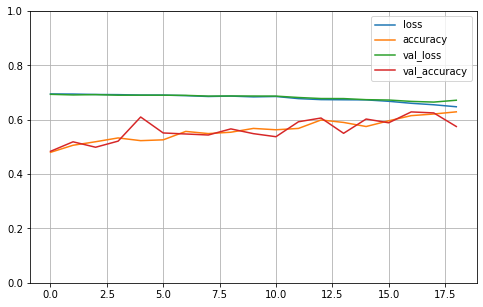

In [42]:
pd.DataFrame(gray_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [43]:
elapsed =after_fit - before_fit
gray_As_duration = elapsed.total_seconds()
print(gray_As_duration)

22.321576


In [44]:
grayy_preds =(gray_model.predict(gray_testX) > 0.6).astype("int32")

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

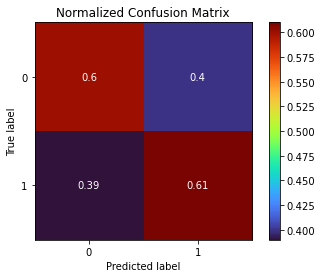

In [45]:
skplt.metrics.plot_confusion_matrix(gray_testy, grayy_preds, normalize=True, cmap='turbo')

In [46]:
TestFeatures = np.load("C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/graytest/gray_KaggleTestImages.npy")
TestFeatures = TestFeatures/255.



In [47]:
TestFeatures.shape

(12500, 64, 64, 1)

In [48]:
As_gray_TestPreds =(gray_model.predict(TestFeatures) > 0.6).astype("int32")
As_gray_TestLabels = As_gray_TestPreds.tolist()
As_gray_TestLabels = [item for sublist in As_gray_TestLabels for item in sublist]
ImageId = np.linspace(1,len(As_gray_TestLabels),len(As_gray_TestLabels))
labels = pd.DataFrame({"id": names, "label": As_gray_TestLabels})
labels.sort_values(by= 'id', inplace = True)
labels.to_csv('As_gray_TestPreds.csv', index=False)

In [49]:
## resubmit
As_gray_KaggleScore = 12.54192

# 5) Kaggle competition RGB images (Train and Predictions)

In [50]:
#Dogphotos = np.load('C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/KaggleTrainDogs.npy')
#scaled_DP = Dogphotos/255.
#grayscaleDogs = np.load('C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/gray_KaggleTrainDogs.npy')
#Catphotos =  np.load('C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/KaggleTrainCats.npy')
#grayscaleCats =  np.load('C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/gray_KaggleTrainCats.npy')
#scaled_grayCats = grayscaleCats/255.
#scaled_grayDogs =  grayscaleDogs/255.
#scaled_CP = Catphotos/255.

#catlabels= np.repeat(0,12500)
#doglabels = np.repeat(1,12500)


In [51]:
#photos = np.append(scaled_CP, scaled_DP, axis=0)
#np.save('KaggleTrainFeatures.npy', photos)
#labels = np.append(catlabels, doglabels, axis=0)
#np.save('KaggleTrainLables.npy',labels)
#grayphotos= np.append(scaled_grayCats, scaled_grayDogs, axis =0)
#np.save('KaggleGrayTrainFeatures.npy',grayphotos)

In [52]:
photos = np.load('KaggleTrainFeatures.npy')
labels = np.load('KaggleTrainLables.npy')
photos = photos/255.

print(photos.shape)
print(labels.shape)

(25000, 64, 64, 3)
(25000,)


'KaggleTrainFeatures.npy', 'KagglegrayTrainFeatures.npy'

In [53]:
X,  y = photos, labels

trainX, testX, trainy, testy = train_test_split( X, y, test_size=0.50, random_state=RANDOM_SEED)
valX, testX, valy, testy = train_test_split( testX, testy, test_size=0.20, random_state=RANDOM_SEED)



In [54]:
trainX.shape

(12500, 64, 64, 3)

In [55]:

model = keras.models.Sequential()
#input convolutional layer
model.add(keras.layers.Conv2D(32, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
model.add(keras.layers.Conv2D(256, (3, 3),1, activation='relu',  padding='same',))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

#flatten and fully connected layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dropout(0.6))

#output layer, binary response
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [56]:
before_fit = datetime.now()


early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=3, patience=18)

optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.1)

model.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
KaggleRGB_history = model.fit(trainX, trainy, epochs=13,
                    validation_data=(valX, valy),
                    callbacks=[tensorboard_cb, early_stopping_cb])

after_fit = datetime.now()


Epoch 1/13
391/391 [==============================] - 16s 38ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 2/13
391/391 [==============================] - 14s 35ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 3/13
391/391 [==============================] - 14s 36ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6927 - val_accuracy: 0.5318
Epoch 4/13
391/391 [==============================] - 13s 33ms/step - loss: 0.6927 - accuracy: 0.5135 - val_loss: 0.6913 - val_accuracy: 0.5453
Epoch 5/13
391/391 [==============================] - 14s 36ms/step - loss: 0.6905 - accuracy: 0.5396 - val_loss: 0.6866 - val_accuracy: 0.5617
Epoch 6/13
391/391 [==============================] - 15s 37ms/step - loss: 0.6850 - accuracy: 0.5578 - val_loss: 0.6804 - val_accuracy: 0.5744
Epoch 7/13
391/391 [==============================] - 14s 36ms/step - loss: 0.6805 - accuracy: 0.5645 - val_loss: 0.6739 - val_accuracy:

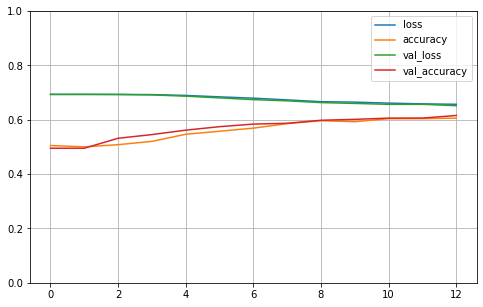

In [57]:
pd.DataFrame(KaggleRGB_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [58]:
elapsed =after_fit - before_fit
RGB_Kg_duration = elapsed.total_seconds()
print(RGB_Kg_duration)

180.763008


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

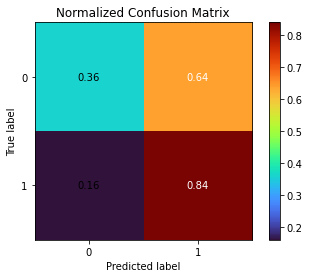

In [59]:
kgRGBy_preds =(model.predict(testX) > 0.45).astype("int32")
skplt.metrics.plot_confusion_matrix(testy, kgRGBy_preds, normalize=True, cmap='turbo')

In [60]:
TestFeatures = np.load("C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/cats_dogs_arrays/KaggleTestImages.npy")
TestFeatures = TestFeatures/255.


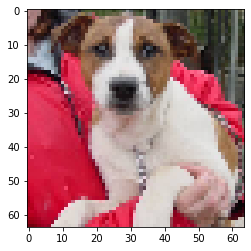

In [61]:
plt.imshow(TestFeatures[20])

In [62]:
Kg_RGB_TestPreds = (model.predict(TestFeatures) > 0.45).astype("int32")
Kg_RGB_TestLabels = Kg_RGB_TestPreds.tolist()
Kg_RGB_TestLabels = [item for sublist in Kg_RGB_TestLabels for item in sublist]
ImageId = np.linspace(1,len(Kg_RGB_TestLabels),len(Kg_RGB_TestLabels))
labels = pd.DataFrame({"id": names, "label": Kg_RGB_TestLabels})
labels.sort_values(by= 'id', inplace = True)
labels.to_csv('Kg_RGB_TestPreds.csv', index=False)

In [63]:
Kg_RGB_Kaggle_Score = 9.03820

# 6) Kaggle competition grayscale images (Train and Predictions)

In [64]:
photos = np.load("C:/Users/bblank/Documents/Northwestern MSDS/MSDS 422 Practical Machine Learning/PythonNotebooks/MSDS422/KaggleGrayTrainFeatures.npy")
labels = np.load("C:/Users/bblank/Documents/Northwestern MSDS/MSDS 422 Practical Machine Learning/PythonNotebooks/MSDS422/KaggleTrainLables.npy")

photos = photos/255.

print(photos.shape)
print(labels.shape)


(25000, 64, 64, 1)
(25000,)


In [65]:
X,  y = photos, labels
gray_trainX, gray_testX, gray_trainy, gray_testy  = train_test_split( X, y, test_size=0.50, random_state=RANDOM_SEED)
gray_valX, gray_testX, gray_valy, gray_testy  = train_test_split( gray_testX, gray_testy, test_size=0.20, random_state=RANDOM_SEED)



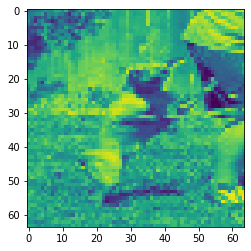

In [66]:
plt.imshow(gray_trainX[188]/255.)

In [67]:
gray_model = keras.models.Sequential()
#input convolutional layer
gray_model.add(keras.layers.Conv2D(32, (8, 8),4, activation='relu', 
    padding='same', input_shape=(64, 64, 1)))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))

#second convolutional and pooling layer with dropout
gray_model.add(keras.layers.Conv2D(64, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#third convolutional layer with dropout
gray_model.add(keras.layers.Conv2D(256, (3, 3),1, activation='relu',  padding='same',))
gray_model.add(keras.layers.MaxPooling2D((2, 2)))
gray_model.add(keras.layers.Dropout(0.2))

#flatten and fully connected layer
gray_model.add(keras.layers.Flatten())
gray_model.add(keras.layers.Dense(500, activation='relu'))
gray_model.add(keras.layers.Dropout(0.6))

#output layer, binary response
gray_model.add(keras.layers.Dense(1, activation='sigmoid'))


In [68]:
before_fit = datetime.now()

early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=3, patience=5)

optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.1)

gray_model.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
Kg_gray_history = gray_model.fit(gray_trainX, gray_trainy, epochs=30,
                    validation_data=(gray_valX, gray_valy),
                    callbacks=[tensorboard_cb, early_stopping_cb])

after_fit = datetime.now()

Epoch 1/30
391/391 [==============================] - 14s 33ms/step - loss: 0.6920 - accuracy: 0.5207 - val_loss: 0.6854 - val_accuracy: 0.5417
Epoch 2/30
391/391 [==============================] - 12s 30ms/step - loss: 0.6825 - accuracy: 0.5681 - val_loss: 0.6516 - val_accuracy: 0.6344
Epoch 3/30
391/391 [==============================] - 12s 31ms/step - loss: 0.6579 - accuracy: 0.6101 - val_loss: 0.6348 - val_accuracy: 0.6387
Epoch 4/30
391/391 [==============================] - 12s 31ms/step - loss: 0.6428 - accuracy: 0.6300 - val_loss: 0.6835 - val_accuracy: 0.5884
Epoch 5/30
391/391 [==============================] - 12s 32ms/step - loss: 0.6403 - accuracy: 0.6357 - val_loss: 0.6508 - val_accuracy: 0.6271
Epoch 6/30
391/391 [==============================] - 12s 31ms/step - loss: 0.6325 - accuracy: 0.6445 - val_loss: 0.5964 - val_accuracy: 0.6819


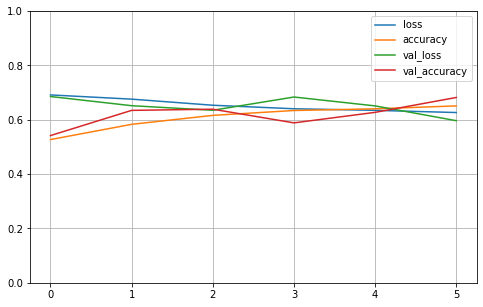

In [69]:
pd.DataFrame(Kg_gray_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [70]:
elapsed =after_fit - before_fit
gray_Kg_duration = elapsed.total_seconds()
print(gray_Kg_duration)

74.537082


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

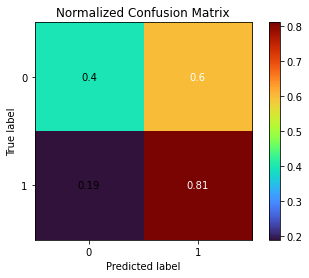

In [71]:
kggrayy_preds =(model.predict(testX) >0.47).astype("int32")
skplt.metrics.plot_confusion_matrix(testy, kggrayy_preds, normalize=True, cmap='turbo')

In [72]:
TestFeatures = np.load("C:/Users/bblank/Documents/Northwestern MSDS/datasets/dogsncats/graytest/gray_KaggleTestImages.npy")
TestFeatures = TestFeatures/255.

#TestFeatures = (TestFeatures-meangX) / stdgX

In [73]:
Kg_gray_TestPreds = (gray_model.predict(TestFeatures) > 0.47).astype("int32")
Kg_gray_TestLabels = Kg_gray_TestPreds.tolist()
Kg_gray_TestLabels = [item for sublist in Kg_gray_TestLabels for item in sublist]
ImageId = np.linspace(1,len(Kg_gray_TestLabels),len(Kg_gray_TestLabels))
labels = pd.DataFrame({"id": names, "label": Kg_gray_TestLabels})
labels.sort_values(by= 'id', inplace = True)
labels.to_csv('Kg_gray_TestPreds.csv', index=False)

In [74]:
Kg_gray_KaggleScore =11.28470

In [75]:
print(RGB_As_duration, gray_As_duration, RGB_Kg_duration, gray_Kg_duration)

22.632664 22.321576 180.763008 74.537082


In [76]:
print(As_RGB_KaggleScore, As_gray_KaggleScore, Kg_RGB_Kaggle_Score, Kg_gray_KaggleScore )

12.16339 12.54192 9.0382 11.2847


In [81]:
AssignmentSummary = {
    'ImageSource': ['Assignment Prompt', 'Assignment Prompt', 'Kaggle', 'Kaggle'], 
    'ColorChannels': [3,1,3,1],
    'Totalbservations': [2000,2000,12500 ,12500 ], 
    'KaggleScores': [As_RGB_KaggleScore, As_gray_KaggleScore,  Kg_RGB_Kaggle_Score, Kg_gray_KaggleScore],
    'TrainingDuration' : [RGB_As_duration, gray_As_duration,  RGB_Kg_duration, gray_Kg_duration]
        }

AssignmentSummary_df = pd.DataFrame.from_dict(AssignmentSummary)
display(AssignmentSummary_df)

,ImageSource,ColorChannels,Totalbservations,KaggleScores,TrainingDuration
0,Assignment Prompt,3,2000,12.16339,22.632664
1,Assignment Prompt,1,2000,12.54192,22.321576
2,Kaggle,3,12500,9.03820,180.763008
3,Kaggle,1,12500,11.28470,74.537082
